In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from tensorflow.keras.applications.xception import Xception

Using TensorFlow backend.


In [2]:
import pathlib
import tensorflow as tf
import preprocess
import numpy as np

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("dataset/training-labels.csv")

In [5]:
data_root = pathlib.Path('dataset/output_combined2')

In [6]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in data_root.iterdir()]
img_path = all_image_paths[-1]
img_raw = tf.read_file(img_path)
img_tensor = tf.image.decode_image(img_raw)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
all_image_files = [ele.split("/")[-1] for ele in all_image_paths]
sub_df = df[df['Filename'].isin(all_image_files)]

In [8]:
sub_df['Filename'] = 'dataset/output_combined2/' + sub_df['Filename'].astype(str)

/home/harrison/.virtualenvs/tensorflow_prob/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
generator = preprocess.tfdata_generator(sub_df['Filename'].values,
                                        sub_df['Drscore'].values,
                                        is_training=True)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [10]:
iterable = generator.make_initializable_iterator()

In [11]:
sess = tf.Session()
sess.run(iterable.initializer)

In [12]:
x,y  = sess.run(iterable.get_next())

In [13]:
base_model = Xception(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(
    generator,
    steps_per_epoch=len(sub_df['Filename'].values)//32,
    epochs=5,
    verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[32,728,37,37] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/RMSprop/gradients/AddN_98-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


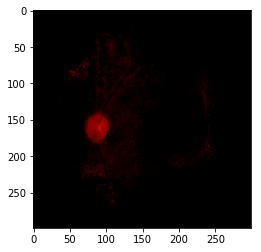

In [50]:
import matplotlib.pyplot as plt
plt.imshow(temp[3])
plt.show()

In [26]:
np.max(temp[0])

1.0

In [3]:
from metrics import quadratic_weighted_kappa
import numpy as np
import tensorflow as tf

In [4]:
actuals = tf.constant([4, 4, 3, 4, 4, 4, 1, 1, 2, 1])
preds   = tf.constant([0, 2, 1, 0, 0, 0, 1, 1, 2, 1])
N = 5

In [5]:
repeat_op = tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N])
repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
weights = tf.cast(repeat_op_sq / (N - 1),tf.dtypes.float32)
O = tf.math.confusion_matrix(actuals,preds,N,dtype=tf.dtypes.float32)
act_hist = tf.math.bincount(actuals)
pred_hist = tf.math.bincount(preds,minlength=N)
E = tf.cast(tf.einsum('i,j->ij',act_hist,pred_hist),dtype=tf.dtypes.float32)
O = O/tf.reduce_sum(O)
E = E/tf.reduce_sum(E)
num = tf.reduce_sum(tf.math.multiply(weights,O))
den = tf.reduce_sum(tf.math.multiply(weights,E))
kappa = 1-num/den

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [6]:
sess = tf.Session()
sess.run(quadratic_weighted_kappa(preds,actuals,N))

Tensor("bincount_2/Bincount:0", shape=(5,), dtype=int32)
Tensor("bincount_3/Bincount:0", shape=(5,), dtype=int32)


-0.1392405

In [40]:
def histogram(ratings, n_classes):
    """
    Returns the counts of each type of rating that a rater made
    """
    hist = np.zeros([n_classes])
    for item in ratings:
        hist[item]+=1
    return hist

In [54]:
from sklearn.metrics import confusion_matrix
actuals = np.array([4, 4, 3, 4, 4, 4, 1, 1, 2, 1])
preds   = np.array([0, 2, 1, 0, 0, 0, 1, 1, 2, 1])
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(preds, actuals, weights='quadratic')

-0.13924050632911378

In [3]:
temp = quadratic_weighted_kappa(preds,actuals,5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Tensor("bincount_1/Bincount:0", shape=(5,), dtype=int32)
Tensor("bincount/Bincount:0", shape=(3,), dtype=int32)


ValueError: Dimensions must be equal, but are 5 and 3 for 'Mul_1' (op: 'Mul') with input shapes: [5,5], [5,3].

In [9]:
temp = tf.contrib.metrics.cohen_kappa(
    tf.constant(actuals),
    tf.constant(preds),
    5,
    weights=None,
    metrics_collections=None,
    updates_collections=None,
    name=None
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [12]:

# find the validation metrics
stream_vars_valid = [v for v in tf.local_variables()]
# reset the total and coutn variables for the metrics
sess.run(tf.variables_initializer(stream_vars_valid))
sess.run(temp)

(0.0, 0.3023255813953489)

In [13]:
0.30**2

0.09